In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as torchdist
import torch.nn as nn

In [2]:
normal_dist = torchdist.Normal(loc=torch.tensor(0.), scale=torch.tensor(1.))

In [3]:
x = normal_dist.sample()

In [4]:
x

tensor(-2.0130)

In [5]:
x = normal_dist.sample([100])

In [6]:
x

tensor([ 0.9616,  0.3605, -0.4014, -0.4002, -0.1052,  0.5479,  0.1007, -0.2665,
        -0.1262, -1.1332, -1.4415,  0.0764,  2.2187,  1.5111,  0.6196,  0.4089,
         0.2174, -3.0862, -0.8464,  0.6394, -1.1484,  0.5680, -0.3714, -0.2363,
         2.2509,  0.9918, -0.2697,  0.1127,  0.1268,  1.0830,  0.2780, -0.7702,
        -1.2388, -0.6926,  0.0843,  0.1200,  1.7642,  0.3699, -1.5614, -1.0109,
         0.3798, -0.3530, -0.6837, -0.0781,  0.8037,  1.1383,  0.5346,  2.0912,
        -0.7815,  0.7456, -1.4438, -1.4000, -0.9568, -0.1315, -0.1923,  0.7989,
         0.9012, -0.2797, -1.5690, -0.5770, -1.4596,  1.2425,  0.8491,  0.4676,
        -2.1965, -0.9050,  0.4784,  0.0970,  1.3199, -0.2216, -0.1236,  0.4936,
         1.1316, -0.3278, -0.3336,  1.6048, -1.4840,  0.8303, -1.7853, -0.2966,
        -0.0899, -0.7539, -1.0077,  2.1583,  0.5253,  0.5420, -0.8863, -1.8048,
        -0.8786, -0.5517,  1.3378,  0.4700, -0.1762,  0.6921, -0.1897, -1.0111,
        -0.1833,  0.6649,  1.8458,  2.41

(array([ 1.,  1.,  8.,  9., 14., 25., 20., 11.,  6.,  5.]),
 array([-3.0862331 , -2.5363674 , -1.9865016 , -1.4366359 , -0.88677007,
        -0.3369043 ,  0.21296148,  0.7628273 ,  1.312693  ,  1.8625588 ,
         2.4124246 ], dtype=float32),
 <a list of 10 Patch objects>)

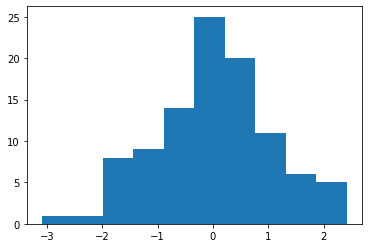

In [7]:
plt.hist(x.detach().numpy())

In [8]:
def toy_poly():
    x = 5 * torch.rand(100, 1)
    linear_op = -3 - 4*x + x**2
    y = torchdist.Normal(linear_op, 1).sample()
    return x, y

x_train, y_train = toy_poly()

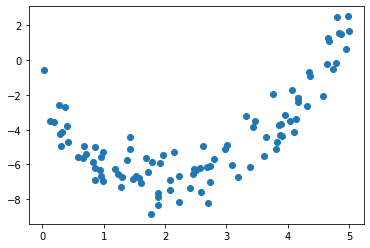

In [9]:
plt.plot(x_train.numpy(), y_train.numpy(), 'o')

## model

In [10]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        
    def forward(self, w, x):
        """
        w: shape of (3,)
        x: shape of (batch,)
        """
        #         phi_x = torch.tensor([])
        y = w[0] + w[1]*x + w[2]*x**2
        return y

In [11]:
class VImodel(nn.Module):
    """
    q(w; eta)
    """
    def __init__(self):
        super(VImodel, self).__init__()
        self.eta_mu = nn.Parameter(torch.tensor([0., 0., 0.]))
        self.eta_log_sigma = nn.Parameter(torch.tensor([0., 0., 0.]))
    
    def dist(self):
        eta_sigma = torch.exp(self.eta_log_sigma)
        q_w = torchdist.Normal(self.eta_mu, eta_sigma)
        
        return q_w
    '''
    def rsample(self):
        eta_sigma = torch.exp(self.eta_log_sigma)
        q_w = torchdist.Normal(self.eta_mu, eta_sigma)
        
        # shape of w: (3,)
        w = q_w.rsample()
        
        return w
    '''

In [12]:
def kl_divergence(vmodel, model, x, y):
    
    q_w = vmodel.dist()
        
    # sampling from q(w)
    w_sample = q_w.rsample()
    # calculate f(x)
    output = model(w_sample, x)    

    # p(y|x,w) = N(f(x; w), 1)
    p_y_xw = torchdist.Normal(output, torch.ones_like(output))
    # p(w) = N(0, 10)
    p_w = torchdist.Normal(torch.tensor([0., 0., 0.]), torch.tensor([10., 10., 10.]))

    # log(p(w, x, y)) = log(p(w)) + 1/n * sigma(log(p(y|x,w)))
    # val_log_joint_prob = p_w.log_prob(w_sample).sum() + p_y_xw.log_prob(y).mean()
    val_log_joint_prob = p_w.log_prob(w_sample).sum() + p_y_xw.log_prob(y).sum()

    val_log_q_w = q_w.log_prob(w_sample).sum()
    
    return val_log_q_w - val_log_joint_prob

In [13]:
vimodel = VImodel()
model = LinearNet()
optimizer = torch.optim.SGD(params=vimodel.parameters(), lr=1e-4)

In [14]:
for i in range(10000):
    optimizer.zero_grad()
    loss = kl_divergence(vimodel, model, x_train, y_train)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 500 == 0 or (i==0):
        mu = vimodel.eta_mu.detach().numpy()
        sigma = torch.exp(vimodel.eta_log_sigma.detach()).numpy()
        print('loss: %f mu: %s sigma: %s' % (loss.detach().numpy(), str(mu), str(sigma)))

loss: 2013.091431 mu: [-0.001784    0.07505579  0.4468731 ] sigma: [1.0003848 1.0103233 0.7889307]
loss: 155.298401 mu: [-3.1582713  -3.6653945   0.90946466] sigma: [0.32767153 0.11272953 0.02774067]
loss: 164.769775 mu: [-3.0553288 -3.8243906  0.8766083] sigma: [0.23775788 0.08225481 0.01870991]
loss: 167.511002 mu: [-2.9662483  -3.9140136   0.93826866] sigma: [0.19818291 0.06609749 0.01623783]
loss: 173.606277 mu: [-2.8785098 -3.9505038  1.010163 ] sigma: [0.1754278  0.05838028 0.01467777]
loss: 155.678009 mu: [-2.8215501 -4.002786   1.0033052] sigma: [0.158059   0.05372329 0.01345732]
loss: 156.706207 mu: [-2.797296   -4.0616984   0.97065324] sigma: [0.14900793 0.05013194 0.01281194]
loss: 154.561813 mu: [-2.7644842  -4.0806713   0.99493927] sigma: [0.14143    0.04753701 0.01225158]
loss: 165.628937 mu: [-2.7406933 -4.0928645  1.0245788] sigma: [0.13427655 0.0449599  0.01167005]
loss: 159.293854 mu: [-2.7272048 -4.1085777  1.0350555] sigma: [0.12865755 0.04286072 0.01123711]
loss: 1

In [15]:
vimodel.eta_mu

Parameter containing:
tensor([-2.6899, -4.1484,  1.0206], requires_grad=True)

In [16]:
torch.exp(vimodel.eta_log_sigma)

tensor([0.1073, 0.0368, 0.0091], grad_fn=<ExpBackward>)

## prediction

Calculate prediction distribution
$$
\begin{align}
p(y_*| x_*, X, Y) &= \int p(y_*| x_*, W) p(W| X, Y) dW \\
&\approx \int p(y_*| x_*, W) q(W; \eta) dW 
\end{align}
$$

In [34]:
def predict(vmodel, model, x, n_samples):
    q_w = vmodel.dist()
    
    approx_y = 0    
    with torch.no_grad():
        for i in range(n_samples):
            # sampling from q(w)
            w_sample = q_w.sample()            
            # calculate f(x)
            output = model(w_sample, x)

            # p(y|x,w) = N(f(x; w), 1)
            p_y_xw = torchdist.Normal(output, torch.ones_like(output))

            # sampling from p(y, w)
            y_sample = p_y_xw.sample()

            approx_y += y_sample / n_samples
    
    return approx_y

In [35]:
def predict_data(vmodel, model):
    n_samples = 100
    x_pred = 5 * torch.rand(100, 1)
    y_pred = predict(vmodel, model, x_pred, n_samples)
    
    return x_pred, y_pred

x_pred, y_pred = predict_data(vimodel, model)

2


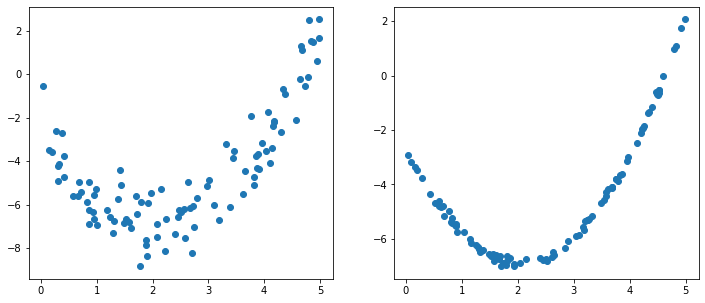

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
print(len(axes))
axes[0].plot(x_train.numpy(), y_train.numpy(), 'o')
axes[1].plot(x_pred.numpy(), y_pred.numpy(), 'o')

In [ ]:
def log_joint_prob(w0, w1, w2, x, y):
    prior_w0 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w1 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w2 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    
    linear = w0 + w1*x + w2*x**2
    likelihood = torchdist.Normal(linear, torch.ones_like(linear))
    
    return (
        prior_w0.log_prob(w0) +
        prior_w1.log_prob(w1) +
        prior_w2.log_prob(w2) +
        likelihood.log_prob(y).mean()
    )

In [49]:
'''
w0 = torch.nn.Parameter(torch.tensor(1.))
w1 = torch.nn.Parameter(torch.tensor(1.))
w2 = torch.nn.Parameter(torch.tensor(1.))

optimizer = torch.optim.Adam(params=[w0, w1, w2], lr=1e-3)

for i in range(30000):
    optimizer.zero_grad()
    log_joint_prob_value = log_joint_prob(w0, w1, w2, x_train, y_train)
    loss_value = - log_joint_prob_value
    loss_value.backward()
    optimizer.step()
    
    if (i+1) % 1000 == 0 or (i==0):
        print(loss_value.detach().numpy())
'''

'\nw0 = torch.nn.Parameter(torch.tensor(1.))\nw1 = torch.nn.Parameter(torch.tensor(1.))\nw2 = torch.nn.Parameter(torch.tensor(1.))\n\noptimizer = torch.optim.Adam(params=[w0, w1, w2], lr=1e-3)\n\nfor i in range(30000):\n    optimizer.zero_grad()\n    log_joint_prob_value = log_joint_prob(w0, w1, w2, x_train, y_train)\n    loss_value = - log_joint_prob_value\n    loss_value.backward()\n    optimizer.step()\n    \n    if (i+1) % 1000 == 0 or (i==0):\n        print(loss_value.detach().numpy())\n'